# Google Sheets Scraper
Goal: scrape the Google Sheet with autofilling data from the Particle Electron at Carlsbad Aquafarm
[Google Sheet named "SeapHOx_OuterLagoon" is here](https://docs.google.com/spreadsheets/d/19jxQzqJa_B5zZJJmd6LmJDA0utKn0NTWoeNK_HkOse4/edit#gid=0)

In [1]:
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

%matplotlib notebook

### Scrape Google Sheets
Run python script from https://developers.google.com/sheets/api/quickstart/python which needs to run separately as it interacts with the web browser (in other words, don't copy and paste script into here.

In [2]:
%run ./quickstart.py
type(values)
print(values[-5:])

[['4/25/2018', '2018/04/25,15:30:25,17.910,0.09015,-0.82131,5.36800,8.22866,336.87399,16.58650,33.70220,3.93,68.48'], ['4/25/2018', '0'], ['4/25/2018', '2018/04/25,16:30:25,17.910,0.08984,-0.82146,5.12300,8.22009,327.09601,17.12000,33.64440,3.93,68.31'], ['4/25/2018', '2018/04/25,17:00:25,17.910,0.08976,-0.82147,4.95700,8.21856,326.97299,16.91990,33.66740,3.92,68.31'], ['4/25/2018', '2018/04/25,17:30:25,17.910,0.08981,-0.82124,4.89600,8.21684,324.27301,17.45530,33.62930,3.93,68.17']]


### Grab Useful Data from Sheet

In [3]:
electron_array = pd.DataFrame(values) # includes timestamp
data_col = electron_array.iloc[:, 1]
data_array = pd.DataFrame(data_col.str.split(',', expand = True)) 
data_array.columns = ['Date', 'Time', 'V_batt', 'V_int', 'V_ext', 'P_dbar', 'pH_int', 'O2_umolkg', 'temp_SBE', 'sal_SBE', 'V_batt_elec', 'charge_status']
data_array.set_index(pd.to_datetime(data_array['Date'] + ' ' + data_array['Time']), inplace = True)
data_array.drop(['Date', 'Time'], axis = 1, inplace = True)
data_array.head()

,V_batt,V_int,V_ext,P_dbar,pH_int,O2_umolkg,temp_SBE,sal_SBE,V_batt_elec,charge_status
2018-04-17 18:30:25,18.860,0.07985,-0.83308,5.33600,8.05349,328.51599,13.43740,33.55860,4.05,84.77
2018-04-17 19:00:25,18.870,0.08055,-0.83331,5.41600,8.08004,328.32300,13.48790,33.56140,4.05,84.62
2018-04-17 19:30:25,18.860,0.08002,-0.83326,5.38800,8.07537,325.82300,13.53800,33.55890,4.05,84.62
2018-04-17 20:02:20,18.860,0.07946,-0.83334,5.35400,8.06744,324.28900,13.54920,33.56210,4.05,84.48
2018-04-17 20:32:51,18.850,0.07959,-0.83293,5.21900,8.06995,326.27499,13.65300,33.56350,4.05,84.48


### Filter
- Filter based on date
- Cast to type float (for some reason the str.split leaves it as arbitrary object)
- This was necessary in early notebook as the input data wasn't filtered at all but the Google Sheet should be cleaner to begin with (*i.e.*, no land data)
- Filtration may come in handy later so keep this here for now

In [4]:
date_filt = data_array.index > '2018-04-17 18:30:00'
data_filt = data_array[date_filt]

import pytz
pacific = pytz.timezone('US/Pacific')
data_filt.index = data_filt.index.tz_localize(pytz.utc).tz_convert(pacific)

data_filt = data_filt.astype('float')

data_filt.tail()
# data_filt.V_press

,V_batt,V_int,V_ext,P_dbar,pH_int,O2_umolkg,temp_SBE,sal_SBE,V_batt_elec,charge_status
2018-04-25 08:00:25-07:00,17.91,0.09039,-0.82104,5.480,8.23255,340.14899,16.5739,33.7037,3.93,68.48
2018-04-25 08:30:25-07:00,17.91,0.09015,-0.82131,5.368,8.22866,336.87399,16.5865,33.7022,3.93,68.48
2018-04-25 09:30:25-07:00,17.91,0.08984,-0.82146,5.123,8.22009,327.09601,17.1200,33.6444,3.93,68.31
2018-04-25 10:00:25-07:00,17.91,0.08976,-0.82147,4.957,8.21856,326.97299,16.9199,33.6674,3.92,68.31
2018-04-25 10:30:25-07:00,17.91,0.08981,-0.82124,4.896,8.21684,324.27301,17.4553,33.6293,3.93,68.17


### Plot

<IPython.core.display.Javascript object>


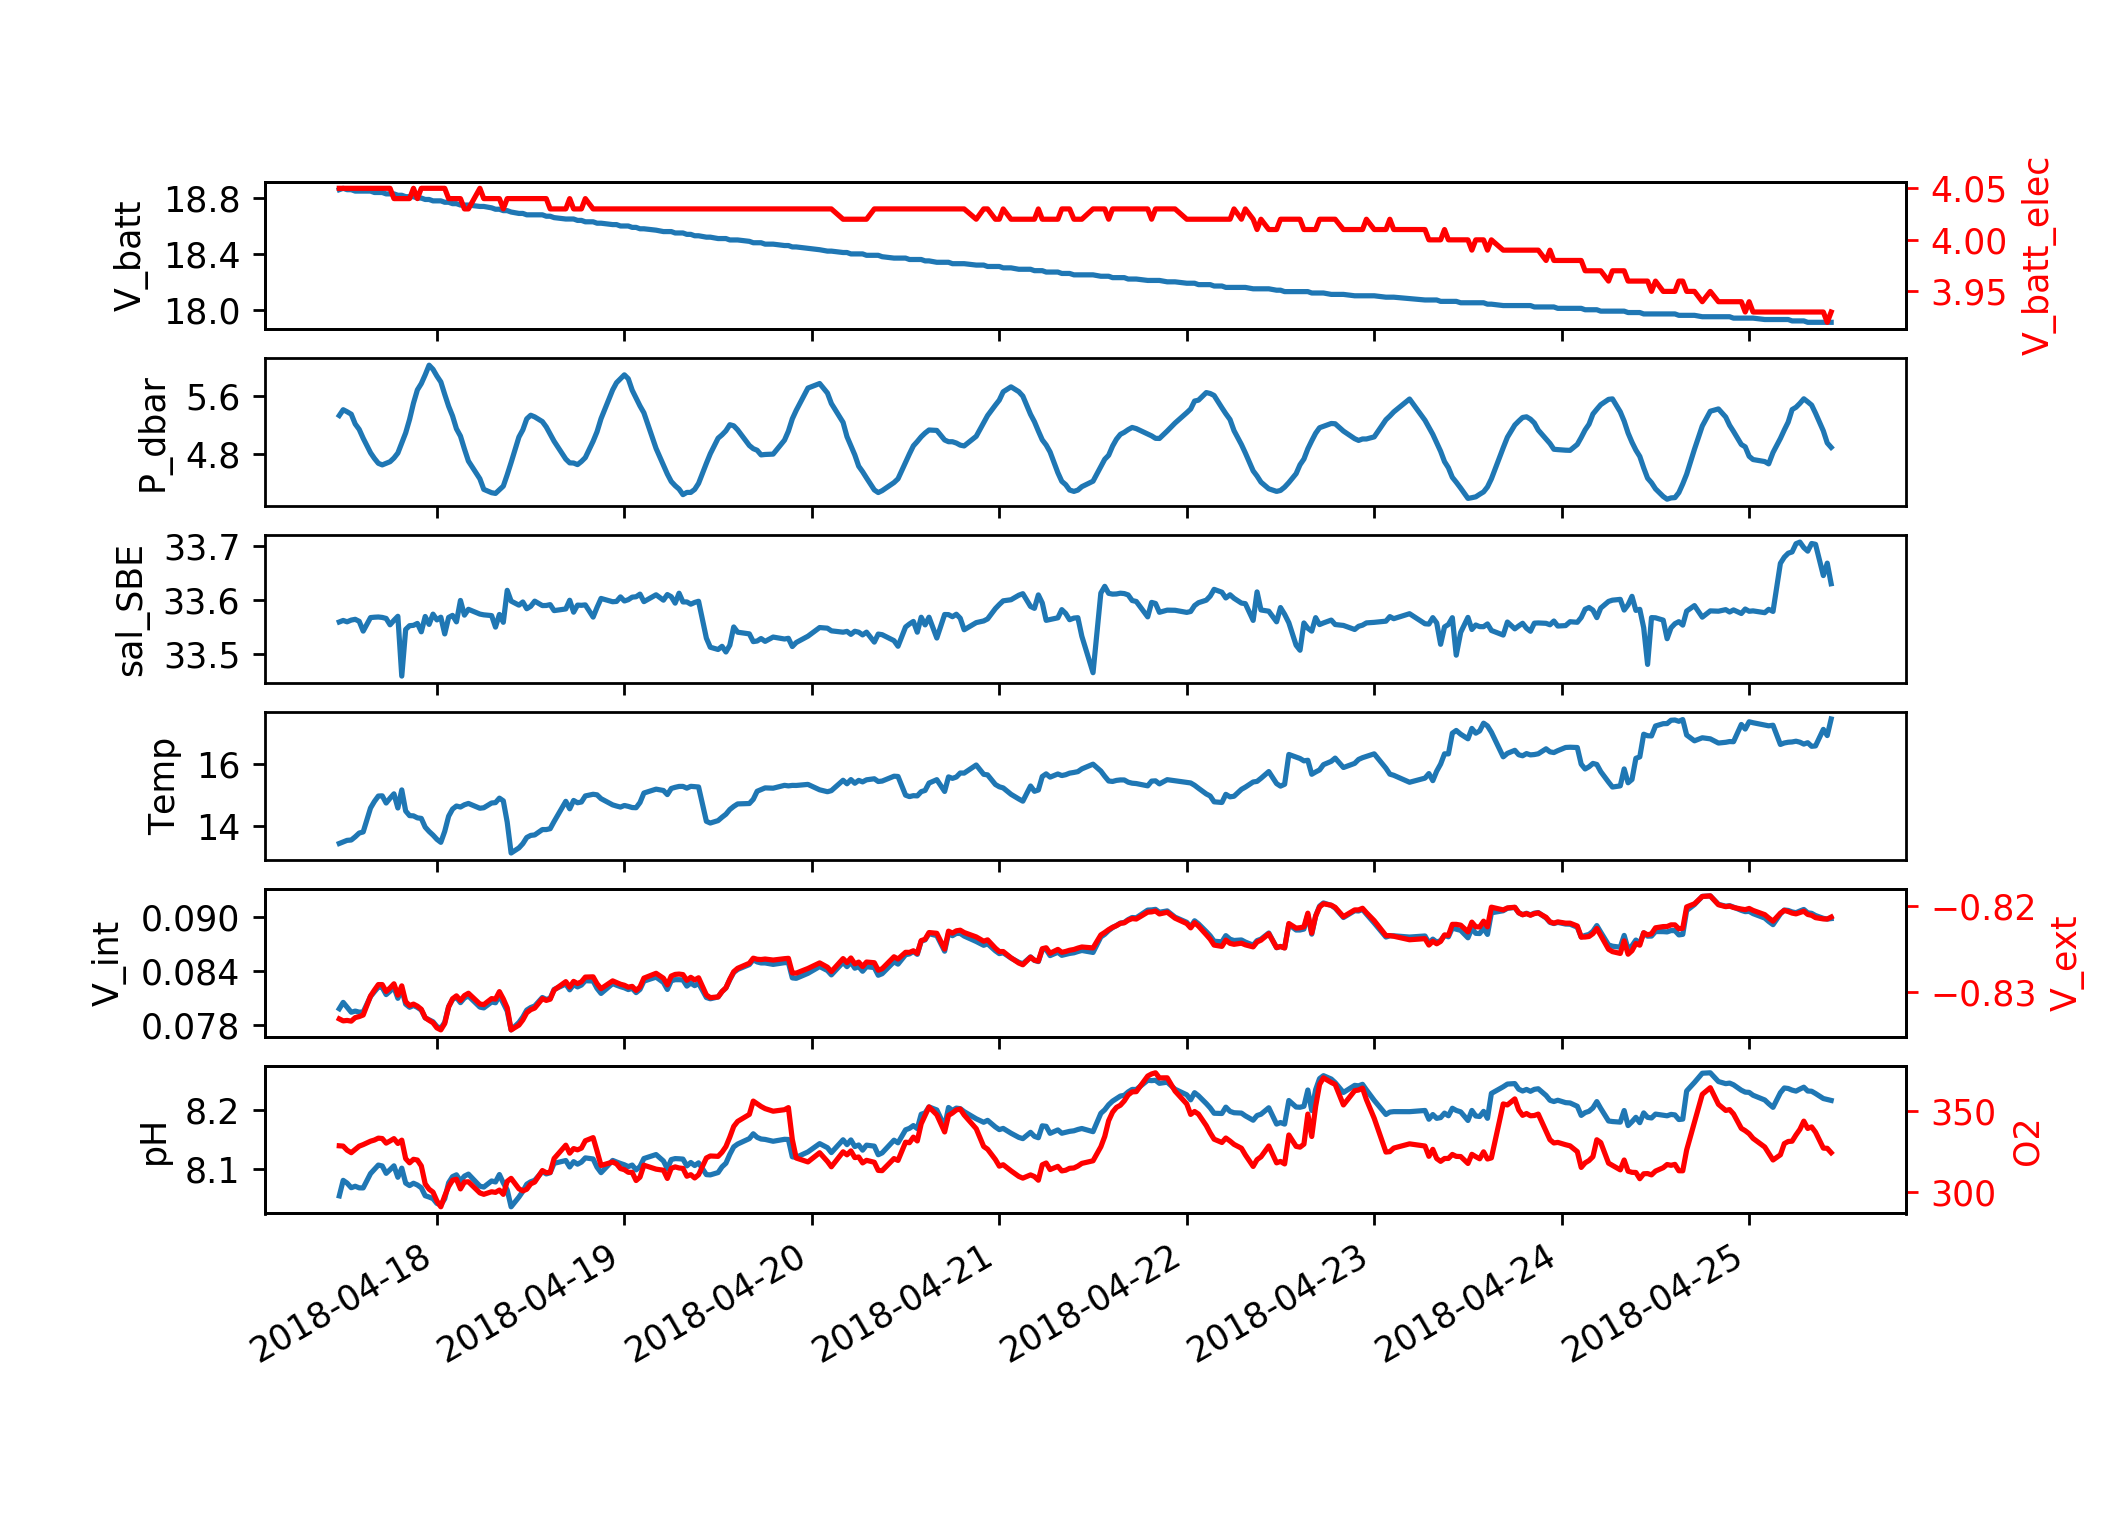

In [5]:
fig, axs = plt.subplots(6, 1, figsize = (6, 6), sharex = True)
axs[0].plot(data_filt.index, data_filt.V_batt)
axs[0].set_ylabel('V_batt')
ax2 = axs[0].twinx()
ax2.plot(data_filt.index, data_filt.V_batt_elec, 'r')
ax2.set_ylabel('V_batt_elec', color='r')
ax2.tick_params('y', colors='r')

axs[1].plot(data_filt.index, data_filt.P_dbar)
axs[1].set_ylabel('P_dbar')

axs[2].plot(data_filt.index, data_filt.sal_SBE)
axs[2].set_ylabel('sal_SBE')

axs[3].plot(data_filt.index, data_filt.temp_SBE)
axs[3].set_ylabel('Temp')

axs[4].plot(data_filt.index, data_filt.V_int)
axs[4].set_ylabel('V_int')
ax2 = axs[4].twinx()
ax2.plot(data_filt.index, data_filt.V_ext, 'r')
ax2.set_ylabel('V_ext', color='r')
ax2.tick_params('y', colors='r')

axs[5].plot(data_filt.index, data_filt.pH_int)
axs[5].set_ylabel('pH')
ax2 = axs[5].twinx()
ax2.plot(data_filt.index, data_filt.O2_umolkg, 'r')
ax2.set_ylabel('O2', color='r')
ax2.tick_params('y', colors='r')

axs[0].xaxis_date() # make sure it knows that x is a date/time

for axi in axs.flat:
#     axi.xaxis.set_major_locator(plt.MaxNLocator(3))
#     print(axi)
    axi.yaxis.set_major_locator(plt.MaxNLocator(3))
#     axi.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.02f"))

fig.autofmt_xdate() # makes the date labels easier to read.

<IPython.core.display.Javascript object>


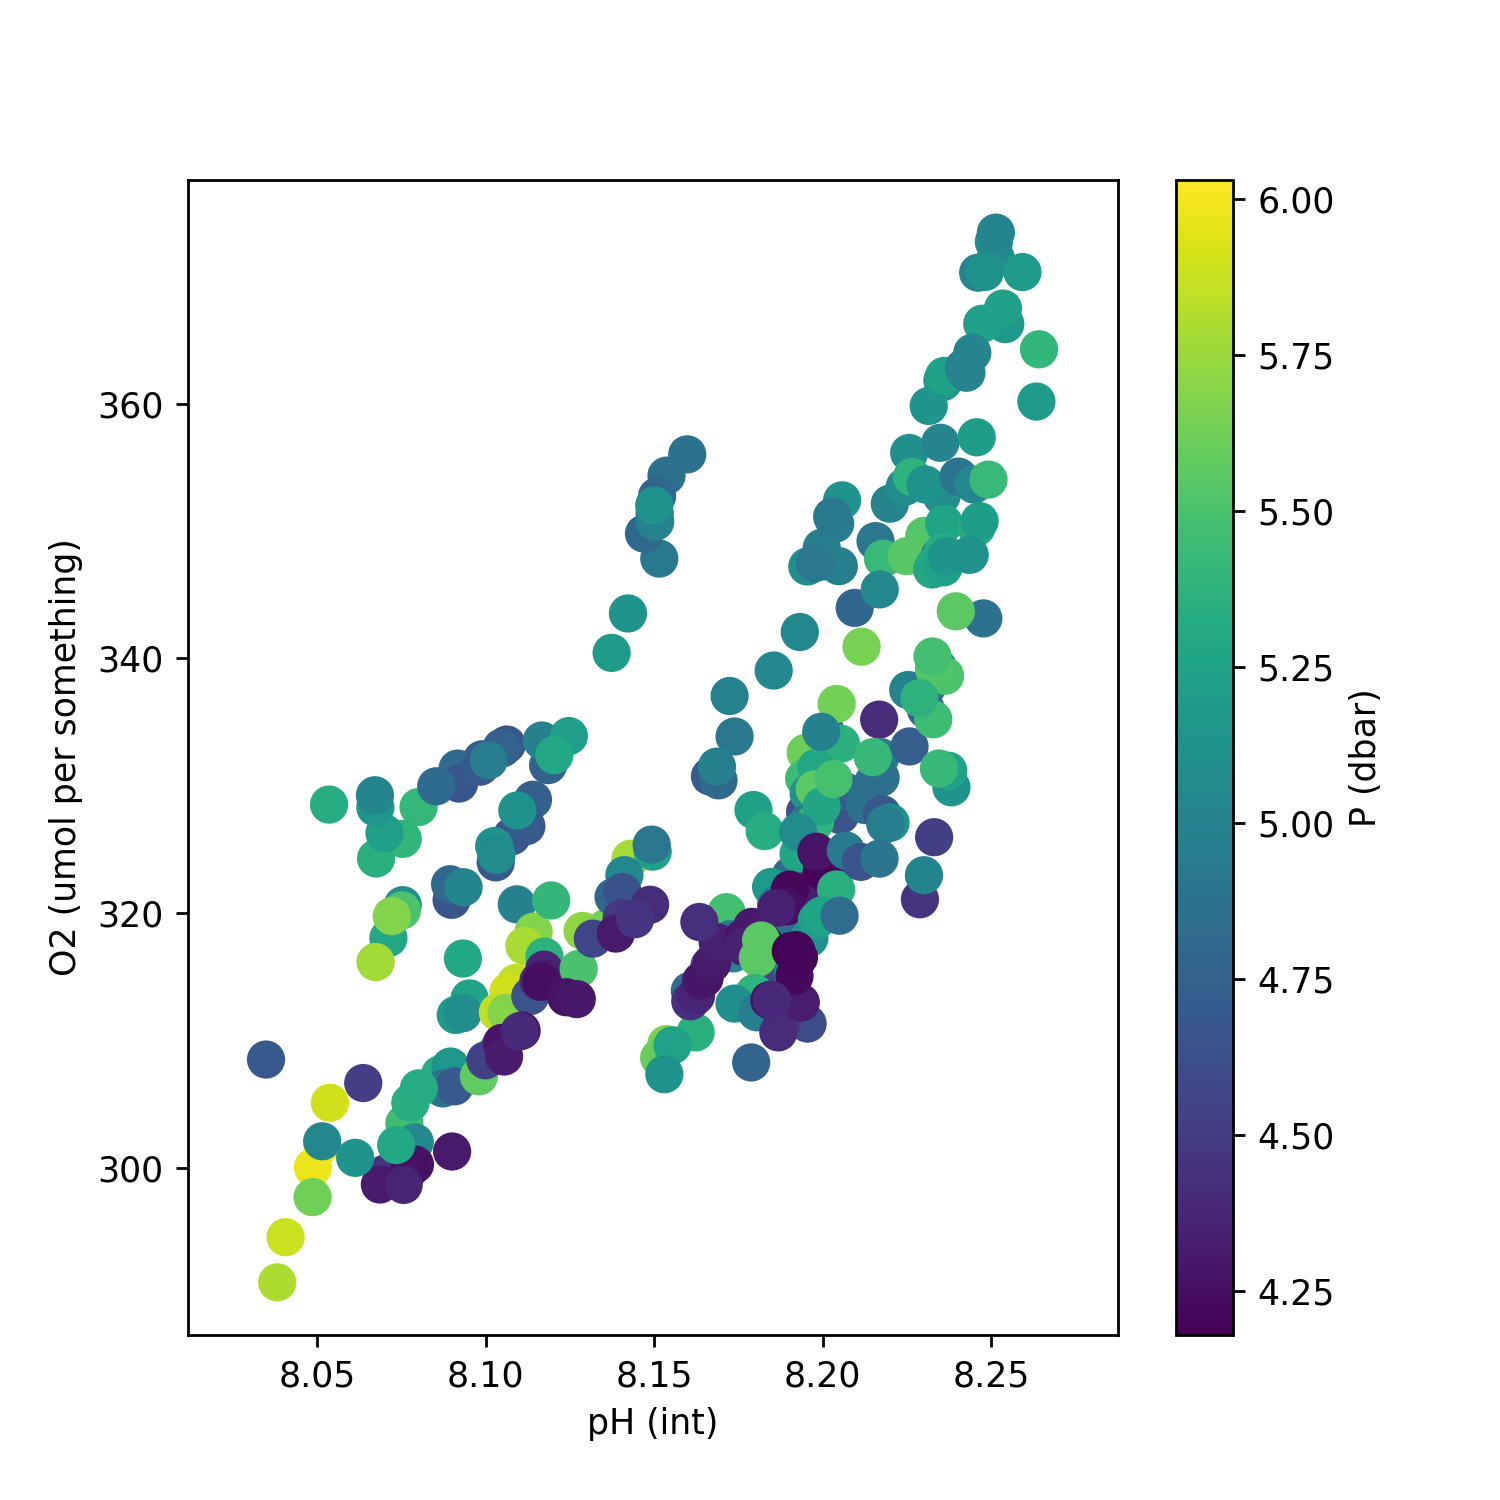

In [6]:
fig, axs = plt.subplots(1, 1, figsize = (6, 6), sharex = True)
pHOx = axs.scatter(x = data_filt.pH_int, 
                   y = data_filt.O2_umolkg, 
                   c = data_filt.P_dbar, 
                   s = 100)
axs.set_xlabel('pH (int)')
axs.set_ylabel('O2 (umol per something)')
plt.colorbar(pHOx, label = 'P (dbar)')  

In [8]:
cmap = plt.get_cmap('coolwarm')
corr = data_filt.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("SeapHOx Correlations")\
    .set_precision(2)